## Imports

In [1]:
from constants import FLUXES_FOLDER, SLM_FOLDER

from data_utils import load_numpy_data, \
                       flatten_data, \
                       shuffle_arrays, \
                       fuse_amplitude_and_phase, \
                       split_data, \
                       normalize_data

from plot_utils import plot_map, \
                       plot_model_history

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_linear_model_for_amplitude_reconstruction, \
                           train_linear_model_for_amplitude_reconstruction

from configurations import FirstWorkingModel

2023-11-27 15:23:56.276239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 15:23:57.162729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load data

In the first place, define the data paths

In [2]:
fluxes_filename = "all_fluxes.npy"
amplitudes_filename = "complexsine_pupamp.npy"
phases_filename = "complexsine_pupphase.npy"

fluxes_path = f"{FLUXES_FOLDER}/{fluxes_filename}"
amplitudes_path = f"{SLM_FOLDER}/{amplitudes_filename}"
phases_path = f"{SLM_FOLDER}/{phases_filename}"

Read the numpy raw files

In [3]:
n_points = 10000
fluxes_array = load_numpy_data(fluxes_path,
                               n_points)

amplitudes_array = load_numpy_data(amplitudes_path,
                                   n_points)

phases_array = load_numpy_data(phases_path,
                               n_points)

Normalize data

In [4]:
fluxes_array, fluxes_scaler = normalize_data(fluxes_array)
amplitudes_array, amplitudes_scaler = normalize_data(amplitudes_array)
phases_array, phases_scaler = normalize_data(phases_array)

Shuffle the data

In [5]:
fluxes_array, amplitudes_array, phases_array = shuffle_arrays([fluxes_array,
                                                               amplitudes_array,
                                                               phases_array])

Merge phase and amplitude

In [6]:
amp_phase_array = fuse_amplitude_and_phase(amplitudes_array,
                                           phases_array)

Flatten input fluxes

In [7]:
flattened_fluxes_array = flatten_data(fluxes_array)
flattened_fluxes_array.shape

(10000, 1320)

Split data in train and validation set

In [8]:
val_ratio = 0.1
train_flattened_fluxes_array, val_flattened_fluxes_array = split_data(flattened_fluxes_array,
                                                                      val_ratio)

train_amp_phase_array, val_amp_phase_array = split_data(amp_phase_array,
                                                        val_ratio)

In [9]:
amp_phase_array.shape

(10000, 2, 96, 96)

In [10]:
train_amp_phase_array.shape

(9000, 2, 96, 96)

In [11]:
train_flattened_fluxes_array.shape

(9000, 1320)

## Define the model

In [12]:
model_configuration = FirstWorkingModel(train_flattened_fluxes_array,
                          train_amp_phase_array)
print(model_configuration.get_description())


	=== AmplitudePhaseReconstructor1 ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: (1320,)
		-Output shape: (2, 96, 96)
		-Hidden layers: [1024, 2048, 2048, 2048]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 1000
		-Batch size: 128
		-Callbacks:
			-Early Stop: MSE 50
			-ReduceLROnPlateau: MSE 15 x0.1
	


2023-11-27 15:24:07.201212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 15:24:07.237894: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 15:24:07.238176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


## Compile model

In [14]:
compile_linear_model_for_amplitude_reconstruction(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [15]:
history = train_linear_model_for_amplitude_reconstruction(
    model,
    train_flattened_fluxes_array,
    train_amp_phase_array,
    val_flattened_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

2023-11-27 15:24:09.041984: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 663552000 exceeds 10% of free system memory.
2023-11-27 15:24:09.614846: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 663552000 exceeds 10% of free system memory.


Epoch 1/1000


2023-11-27 15:24:11.375826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-27 15:24:11.390116: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f4fc330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 15:24:11.390162: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-27 15:24:11.401531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 15:24:11.677239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-27 15:24:11.878174: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime o

71/71 [==============================] - 4s 22ms/step - loss: 0.8467 - mean_squared_error: 0.8467 - val_loss: 0.8199 - val_mean_squared_error: 0.8199 - lr: 0.0010
Epoch 2/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8340 - mean_squared_error: 0.8340 - val_loss: 0.8191 - val_mean_squared_error: 0.8191 - lr: 0.0010
Epoch 3/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8335 - mean_squared_error: 0.8335 - val_loss: 0.8202 - val_mean_squared_error: 0.8202 - lr: 0.0010
Epoch 4/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8333 - mean_squared_error: 0.8333 - val_loss: 0.8174 - val_mean_squared_error: 0.8174 - lr: 0.0010
Epoch 5/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8334 - mean_squared_error: 0.8334 - val_loss: 0.8176 - val_mean_squared_error: 0.8176 - lr: 0.0010
Epoch 6/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8325 - mean_squared_error: 0.8325 - val_loss: 0.8170 - v

71/71 [==============================] - 1s 19ms/step - loss: 0.8128 - mean_squared_error: 0.8128 - val_loss: 0.8297 - val_mean_squared_error: 0.8297 - lr: 0.0010
Epoch 48/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8379 - val_mean_squared_error: 0.8379 - lr: 0.0010
Epoch 49/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8066 - mean_squared_error: 0.8066 - val_loss: 0.8394 - val_mean_squared_error: 0.8394 - lr: 0.0010
Epoch 50/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.8035 - mean_squared_error: 0.8035 - val_loss: 0.8395 - val_mean_squared_error: 0.8395 - lr: 0.0010
Epoch 51/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.7988 - mean_squared_error: 0.7988 - val_loss: 0.8436 - val_mean_squared_error: 0.8436 - lr: 0.0010
Epoch 52/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.7935 - mean_squared_error: 0.7935 - val_loss: 0.845

71/71 [==============================] - 1s 19ms/step - loss: 0.2798 - mean_squared_error: 0.2798 - val_loss: 1.1705 - val_mean_squared_error: 1.1705 - lr: 0.0010
Epoch 94/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2729 - mean_squared_error: 0.2729 - val_loss: 1.1750 - val_mean_squared_error: 1.1750 - lr: 0.0010
Epoch 95/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2638 - mean_squared_error: 0.2638 - val_loss: 1.1721 - val_mean_squared_error: 1.1721 - lr: 0.0010
Epoch 96/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 1.1768 - val_mean_squared_error: 1.1768 - lr: 0.0010
Epoch 97/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 1.1787 - val_mean_squared_error: 1.1787 - lr: 0.0010
Epoch 98/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 1.196

71/71 [==============================] - 1s 19ms/step - loss: 0.1352 - mean_squared_error: 0.1352 - val_loss: 1.2693 - val_mean_squared_error: 1.2693 - lr: 0.0010
Epoch 140/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 1.2599 - val_mean_squared_error: 1.2599 - lr: 0.0010
Epoch 141/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1326 - mean_squared_error: 0.1326 - val_loss: 1.2776 - val_mean_squared_error: 1.2776 - lr: 0.0010
Epoch 142/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1309 - mean_squared_error: 0.1309 - val_loss: 1.2735 - val_mean_squared_error: 1.2735 - lr: 0.0010
Epoch 143/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 1.2699 - val_mean_squared_error: 1.2699 - lr: 0.0010
Epoch 144/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 1.2870 - val_mean_squared_error: 1.2870 - lr: 0.0010
Epoch 186/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1068 - mean_squared_error: 0.1068 - val_loss: 1.2944 - val_mean_squared_error: 1.2944 - lr: 0.0010
Epoch 187/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - val_loss: 1.2843 - val_mean_squared_error: 1.2843 - lr: 0.0010
Epoch 188/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1076 - mean_squared_error: 0.1076 - val_loss: 1.2829 - val_mean_squared_error: 1.2829 - lr: 0.0010
Epoch 189/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1067 - mean_squared_error: 0.1067 - val_loss: 1.2774 - val_mean_squared_error: 1.2774 - lr: 0.0010
Epoch 190/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.1071 - mean_squared_error: 0.1071 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.0972 - mean_squared_error: 0.0972 - val_loss: 1.2762 - val_mean_squared_error: 1.2762 - lr: 0.0010
Epoch 232/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0978 - mean_squared_error: 0.0978 - val_loss: 1.2754 - val_mean_squared_error: 1.2754 - lr: 0.0010
Epoch 233/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - val_loss: 1.2748 - val_mean_squared_error: 1.2748 - lr: 0.0010
Epoch 234/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 1.2855 - val_mean_squared_error: 1.2855 - lr: 0.0010
Epoch 235/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0953 - mean_squared_error: 0.0953 - val_loss: 1.2780 - val_mean_squared_error: 1.2780 - lr: 0.0010
Epoch 236/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0947 - mean_squared_error: 0.0947 - val_loss: 

71/71 [==============================] - 1s 19ms/step - loss: 0.0642 - mean_squared_error: 0.0642 - val_loss: 1.2956 - val_mean_squared_error: 1.2956 - lr: 1.0000e-04
Epoch 276/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 1.2963 - val_mean_squared_error: 1.2963 - lr: 1.0000e-04
Epoch 277/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - val_loss: 1.2963 - val_mean_squared_error: 1.2963 - lr: 1.0000e-04
Epoch 278/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 1.2975 - val_mean_squared_error: 1.2975 - lr: 1.0000e-04
Epoch 279/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 1.2988 - val_mean_squared_error: 1.2988 - lr: 1.0000e-04
Epoch 280/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0638 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 1.3238 - val_mean_squared_error: 1.3238 - lr: 1.0000e-04
Epoch 321/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 1.3250 - val_mean_squared_error: 1.3250 - lr: 1.0000e-04
Epoch 322/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 1.3263 - val_mean_squared_error: 1.3263 - lr: 1.0000e-04
Epoch 323/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 1.3270 - val_mean_squared_error: 1.3270 - lr: 1.0000e-04
Epoch 324/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 1.3267 - val_mean_squared_error: 1.3267 - lr: 1.0000e-04
Epoch 325/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0607 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - val_loss: 1.3493 - val_mean_squared_error: 1.3493 - lr: 1.0000e-04
Epoch 366/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - val_loss: 1.3517 - val_mean_squared_error: 1.3517 - lr: 1.0000e-04
Epoch 367/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 1.3511 - val_mean_squared_error: 1.3511 - lr: 1.0000e-04
Epoch 368/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 1.3511 - val_mean_squared_error: 1.3511 - lr: 1.0000e-04
Epoch 369/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 1.3513 - val_mean_squared_error: 1.3513 - lr: 1.0000e-04
Epoch 370/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0582 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 1.3734 - val_mean_squared_error: 1.3734 - lr: 1.0000e-04
Epoch 411/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 1.3741 - val_mean_squared_error: 1.3741 - lr: 1.0000e-04
Epoch 412/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 1.3744 - val_mean_squared_error: 1.3744 - lr: 1.0000e-04
Epoch 413/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 1.3735 - val_mean_squared_error: 1.3735 - lr: 1.0000e-04
Epoch 414/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 1.3755 - val_mean_squared_error: 1.3755 - lr: 1.0000e-04
Epoch 415/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0563 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 1.3960 - val_mean_squared_error: 1.3960 - lr: 1.0000e-04
Epoch 456/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 1.3955 - val_mean_squared_error: 1.3955 - lr: 1.0000e-04
Epoch 457/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 1.3958 - val_mean_squared_error: 1.3958 - lr: 1.0000e-04
Epoch 458/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - val_loss: 1.3979 - val_mean_squared_error: 1.3979 - lr: 1.0000e-04
Epoch 459/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0547 - mean_squared_error: 0.0547 - val_loss: 1.3970 - val_mean_squared_error: 1.3970 - lr: 1.0000e-04
Epoch 460/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0547 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 1.4166 - val_mean_squared_error: 1.4166 - lr: 1.0000e-04
Epoch 501/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - val_loss: 1.4172 - val_mean_squared_error: 1.4171 - lr: 1.0000e-04
Epoch 502/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 1.4177 - val_mean_squared_error: 1.4177 - lr: 1.0000e-04
Epoch 503/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 1.4185 - val_mean_squared_error: 1.4185 - lr: 1.0000e-04
Epoch 504/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - val_loss: 1.4178 - val_mean_squared_error: 1.4178 - lr: 1.0000e-04
Epoch 505/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0534 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 1.4365 - val_mean_squared_error: 1.4365 - lr: 1.0000e-04
Epoch 546/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0523 - mean_squared_error: 0.0523 - val_loss: 1.4369 - val_mean_squared_error: 1.4369 - lr: 1.0000e-04
Epoch 547/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.4367 - val_mean_squared_error: 1.4367 - lr: 1.0000e-04
Epoch 548/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.4375 - val_mean_squared_error: 1.4375 - lr: 1.0000e-04
Epoch 549/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 1.4383 - val_mean_squared_error: 1.4383 - lr: 1.0000e-04
Epoch 550/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0522 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 1.4543 - val_mean_squared_error: 1.4543 - lr: 1.0000e-04
Epoch 591/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 1.4553 - val_mean_squared_error: 1.4553 - lr: 1.0000e-04
Epoch 592/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 1.4557 - val_mean_squared_error: 1.4557 - lr: 1.0000e-04
Epoch 593/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 1.4560 - val_mean_squared_error: 1.4560 - lr: 1.0000e-04
Epoch 594/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 1.4565 - val_mean_squared_error: 1.4565 - lr: 1.0000e-04
Epoch 595/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0512 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 1.4742 - val_mean_squared_error: 1.4742 - lr: 1.0000e-04
Epoch 636/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 1.4731 - val_mean_squared_error: 1.4731 - lr: 1.0000e-04
Epoch 637/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0503 - mean_squared_error: 0.0503 - val_loss: 1.4748 - val_mean_squared_error: 1.4748 - lr: 1.0000e-04
Epoch 638/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 1.4755 - val_mean_squared_error: 1.4755 - lr: 1.0000e-04
Epoch 639/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 1.4752 - val_mean_squared_error: 1.4752 - lr: 1.0000e-04
Epoch 640/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0502 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4916 - val_mean_squared_error: 1.4916 - lr: 1.0000e-04
Epoch 681/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4921 - val_mean_squared_error: 1.4921 - lr: 1.0000e-04
Epoch 682/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4920 - val_mean_squared_error: 1.4920 - lr: 1.0000e-04
Epoch 683/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4913 - val_mean_squared_error: 1.4913 - lr: 1.0000e-04
Epoch 684/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 1.4923 - val_mean_squared_error: 1.4923 - lr: 1.0000e-04
Epoch 685/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0495 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 1.5078 - val_mean_squared_error: 1.5078 - lr: 1.0000e-04
Epoch 726/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 1.5086 - val_mean_squared_error: 1.5086 - lr: 1.0000e-04
Epoch 727/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 1.5091 - val_mean_squared_error: 1.5091 - lr: 1.0000e-04
Epoch 728/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 1.5095 - val_mean_squared_error: 1.5095 - lr: 1.0000e-04
Epoch 729/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 1.5095 - val_mean_squared_error: 1.5095 - lr: 1.0000e-04
Epoch 730/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0488 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 1.5239 - val_mean_squared_error: 1.5239 - lr: 1.0000e-04
Epoch 771/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 1.5246 - val_mean_squared_error: 1.5246 - lr: 1.0000e-04
Epoch 772/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 1.5254 - val_mean_squared_error: 1.5254 - lr: 1.0000e-04
Epoch 773/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 1.5239 - val_mean_squared_error: 1.5239 - lr: 1.0000e-04
Epoch 774/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 1.5255 - val_mean_squared_error: 1.5255 - lr: 1.0000e-04
Epoch 775/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0481 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.5385 - val_mean_squared_error: 1.5385 - lr: 1.0000e-04
Epoch 816/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 1.5400 - val_mean_squared_error: 1.5400 - lr: 1.0000e-04
Epoch 817/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 1.5401 - val_mean_squared_error: 1.5401 - lr: 1.0000e-04
Epoch 818/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 1.5417 - val_mean_squared_error: 1.5417 - lr: 1.0000e-04
Epoch 819/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 1.5414 - val_mean_squared_error: 1.5414 - lr: 1.0000e-04
Epoch 820/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0475 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 1.5546 - val_mean_squared_error: 1.5546 - lr: 1.0000e-04
Epoch 861/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 1.5548 - val_mean_squared_error: 1.5548 - lr: 1.0000e-04
Epoch 862/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 1.5557 - val_mean_squared_error: 1.5557 - lr: 1.0000e-04
Epoch 863/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 1.5570 - val_mean_squared_error: 1.5570 - lr: 1.0000e-04
Epoch 864/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 1.5564 - val_mean_squared_error: 1.5564 - lr: 1.0000e-04
Epoch 865/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0470 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.5703 - val_mean_squared_error: 1.5703 - lr: 1.0000e-04
Epoch 906/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.5691 - val_mean_squared_error: 1.5691 - lr: 1.0000e-04
Epoch 907/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.5713 - val_mean_squared_error: 1.5713 - lr: 1.0000e-04
Epoch 908/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.5711 - val_mean_squared_error: 1.5711 - lr: 1.0000e-04
Epoch 909/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.5698 - val_mean_squared_error: 1.5698 - lr: 1.0000e-04
Epoch 910/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0464 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.5838 - val_mean_squared_error: 1.5838 - lr: 1.0000e-04
Epoch 951/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.5840 - val_mean_squared_error: 1.5840 - lr: 1.0000e-04
Epoch 952/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.5845 - val_mean_squared_error: 1.5845 - lr: 1.0000e-04
Epoch 953/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.5840 - val_mean_squared_error: 1.5840 - lr: 1.0000e-04
Epoch 954/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 1.5853 - val_mean_squared_error: 1.5853 - lr: 1.0000e-04
Epoch 955/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0460 - mean_squared_error:

71/71 [==============================] - 1s 19ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 1.5977 - val_mean_squared_error: 1.5977 - lr: 1.0000e-04
Epoch 996/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 1.5991 - val_mean_squared_error: 1.5991 - lr: 1.0000e-04
Epoch 997/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 1.5985 - val_mean_squared_error: 1.5985 - lr: 1.0000e-04
Epoch 998/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 1.5991 - val_mean_squared_error: 1.5991 - lr: 1.0000e-04
Epoch 999/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 1.5989 - val_mean_squared_error: 1.5989 - lr: 1.0000e-04
Epoch 1000/1000
71/71 [==============================] - 1s 19ms/step - loss: 0.0455 - mean_squared_error

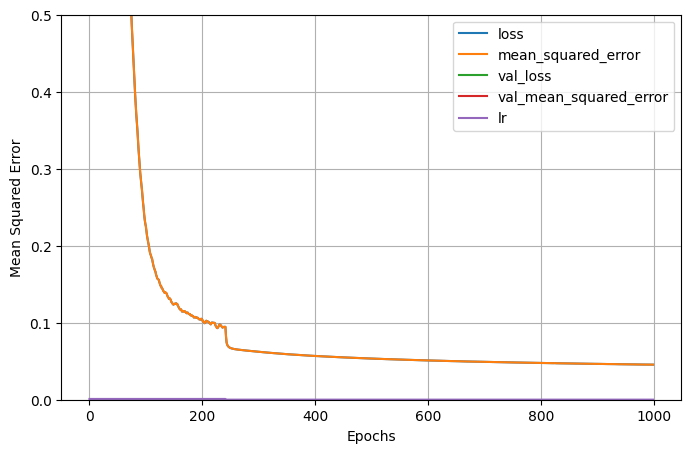

In [16]:
plot_model_history(history)

In [27]:
n = 53
plot_map(val_amp_phase_array[n][0])
plot_map(val_amp_phase_array[n][1])
im = model.predict(val_flattened_fluxes_array[n].reshape(1,1320))
plot_map(im[0][0])
plot_map(im[0][1])
plot_map(val_flattened_fluxes_array[n].reshape(fluxes_array[n].shape))

1/1 [==============================] - 0s 16ms/step
